In [2]:
datafile_km = '../data/all_frames_wclust.pkl.xz' # with AU6_AU12 clusters
datafile_bmm = '../data/all_frames_clust.bmm.pkl.xz' # bmm with 5 clusters
datafile_bmm9 = '../data/all_frames_clust.bmm9.pkl.xz' # bmm clusters

CONFIDENCE_TOL = 0.90 # only use data with conf > this

#-----------------

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.4f}'.format
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
# import in scripts dir
import sys
sys.path.append('../scripts')
import compare 

cluster_name2i = {'duchenne':0,'neutral':1,'strong duchenne':2,'6 only':3,'polite':4}
cluster_name2i_bmm9 = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8}

def load_cluster_data(datafile):
    print('\n...loading cluster data: ', datafile)
    if 'pkl' in datafile:
        df = pd.read_pickle(datafile)
    else:
        df = pd.read_csv(datafile, skipinitialspace=True) 
    df = df[df['confidence'] >= CONFIDENCE_TOL]
    # confidence of .90 causes nfiles 302-->298

    if 'bmm9' in datafile:
        for cluster_name in cluster_name2i_bmm9.keys():
            df[cluster_name] = (df['AU06_AU12_cluster'] == cluster_name2i_bmm9[cluster_name]).astype(int)
    else:
        for cluster_name in cluster_name2i.keys():
            df[cluster_name] = (df['AU06_AU12_cluster'] == cluster_name2i[cluster_name]).astype(int)

    print('n:',df.shape[0])
    print('# files = ', df['Filename'].nunique())

    print('\ncolumns: ')
    for c in df.columns:
        print(c,end=',')
    print('-------')
    return df
        
#df_km = load_cluster_data(datafile_km)
#df_bmm = load_cluster_data(datafile_bmm)
df_bmm9 = load_cluster_data(datafile_bmm9)


...loading cluster data:  ../data/all_frames_clust.bmm9.pkl.xz
n: 1246319
# files =  298

columns: 
Filename,filetype,confidence,segment,timestamp,AU06_AU12_cluster,5,1,6,4,2,7,3,8,0,-------


In [3]:
#adding gender
genderdat = '../data/old_data_gender.csv'
Gen_df=pd.read_csv(genderdat)

df_bmm9 = df_bmm9[(df_bmm9['segment']=='S2')& (df_bmm9['filetype'].str.contains('W'))]

df_bmm9['root']=df_bmm9['Filename'].str.split('-W').str[0]

dfGenbmm9=pd.merge(df_bmm9, Gen_df, how = 'left', left_on = 'root', right_on = 'root')

df_bmm9_gr=pd.DataFrame(dfGenbmm9.groupby(['root']).mean().dropna())

print(df_bmm9_gr.shape)

(143, 16)


In [30]:
# initialize classifier function
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

def ml(df,MODEL,weight_plot=0):
    """ Runs either logistic regression or KNN through sklearn using both 
        dev and test set. """
    print (MODEL)
    N_FOLDS = 10
    ACC_THRESH = 0.01 # dev set accuracy must be x% better to use new param
    #MODEL = 'LOGISTIC' 
    #MODEL = 'KNN'
    #MODEL = 'DT'
    
    FEATURES = ['S2_ AU12_r_var','SD_ AU23_c_avg', \
                'S1_ AU01_c_avg','S2_ AU06_r_var',\
                'S2_ AU25_c_avg', 'SD_abs_d_pose_Rx_var']
    #FEATURES = ['S2_ AU12_c_avg','S2_ AU06_c_avg']


    if MODEL == 'LOGISTIC':
        c_l = [0.01,0.03, 0.1, 0.3, 1,3,10,30,100,300,1000,3000,10000]
    elif MODEL == 'KNN':       
        c_l = [25,20,18,15,10,8,9,8,7,6,3,2]
    elif MODEL == "DT":
        c_l =[1,2,3,4,5,6,7,8,9,10]
    elif MODEL == "SVC":
        c_l = [0.01,0.03, 0.1, 0.3, 1,3,10,30,100,300,1000,3000,10000]
    regularizer = 'l1'
    
    # only get features we want that are not nan
    #df_good = df.loc[:,['y'] + FEATURES]
    df_good = df#[['y','AU06_r','AU12_r','witness_is_male']] # Naven pick the features, or, this uses all
    df_good = df_good.dropna()
        
    X_nd = df_good.drop('y',axis=1).values

    X_nd = scale(X_nd) # magnitude has useful info?
  
    y_n = df_good['y'].values.astype(bool)
    skf = StratifiedKFold(shuffle = True, n_splits=N_FOLDS, random_state=7)

    acc_test_a = np.zeros(N_FOLDS)
    acc_train_a = np.zeros(N_FOLDS)
    
    ncol = len(X_nd[0])
    weight_list = [0]* ncol
    for i, (train, test) in enumerate(skf.split(X_nd,y_n)):
        train_n = len(train)
        dev = train[:int(train_n/4)]  # empirically found that dev 1/4 is good
        sub_train = train[int(train_n/4):] # this is temporary train set
        best_acc = 0
        best_c = None
        # in this loop we find best hyper parameter for this split
        for c in c_l:
            if MODEL == 'LOGISTIC': 
                clf = linear_model.LogisticRegression(penalty=regularizer,C=c)
            elif MODEL == 'KNN':
               # if c<=(len(df_good.index)/2):
                clf = KNeighborsClassifier(n_neighbors=c, metric='euclidean',weights='uniform')
            elif MODEL == 'DT':
                clf = DecisionTreeClassifier (max_depth = c)
            elif MODEL == 'SVC':
                clf = SVC (C=c,kernel = 'rbf')

            clf.fit(X_nd[sub_train], y_n[sub_train])
            y_pred = clf.predict(X_nd[dev])
            acc = metrics.accuracy_score(y_pred,y_n[dev])
            if(acc > best_acc + ACC_THRESH):
                best_acc = acc
                best_c = c

        # retrain with all train data and best_c
        print('fold:',i,' best c:',best_c, ' dev:%.2f' % best_acc, ' dev_ones:%.2f' % (y_n[dev].sum()/len(dev)),end='')
        if MODEL == 'LOGISTIC': 
            clf = linear_model.LogisticRegression(penalty=regularizer,C=best_c)
        elif MODEL == 'KNN':           
            clf = KNeighborsClassifier(n_neighbors=best_c, metric='euclidean',weights='uniform')
        elif MODEL == 'DT':
            clf = DecisionTreeClassifier(max_depth =best_c)
        elif MODEL == 'SVC':
            clf = SVC(C=best_c,kernel ='rbf')
        clf.fit(X_nd[train],y_n[train])
        #applicable for logisitic regression
            #Using dictionary to keep track of the number of times the weights were 0
        d= df_good.drop('y',axis=1)
        clust = list(d.columns.values)
        if weight_plot == 1:
            coeff=clf.coef_[0]
            weights_dict= dict(zip(clust,coeff))
            wn0= {}
            for k, v in weights_dict.items():
                if v == 0:
                    wn0[k] = v
            print ('  ',wn0)
            weight_list = [x+y for x,y in zip(coeff,weight_list)]
        
        #plotting the model
        
#         plt.figure(1, figsize=(4, 3))
#         plt.plot(X_nd, clf.coef_ * X_nd + clf.intercept_, linewidth=1)
#         print(X_nd.shape,y_n.shape)
#         #plt.scatter(X_nd, y_n, color='black', zorder=20)
#         plt.show()
        
        y_pred = clf.predict(X_nd)
        acc_test_a[i] = metrics.accuracy_score(y_pred[test],y_n[test])
        acc_train_a[i] = metrics.accuracy_score(y_pred[train],y_n[train])
        print(' test:%.2f' % acc_test_a[i], ' train:%.2f' % acc_train_a[i])                   
                
    print('Avg test acc:%.3f' % acc_test_a.mean(),'Avg train acc:%.3f' % acc_train_a.mean())   
    
    # plotting the weights for logisitic regression
    if weight_plot == 1:
        avgWeights= [x/N_FOLDS for x in weight_list]
        x= clust
        pos =[x for x in range(0,len(x))]
        plt.bar(pos,avgWeights, align='center', alpha=0.5)
        plt.xticks(pos, x)
        plt.ylabel('Avg Weight')
        plt.title('Weights of features from Logisitic Regression')
        plt.show()
    

In [5]:
df_bmm9_gr['y']=df_bmm9_gr['describer_job_is_truth']
usecols= ['y','0','1','2','3','4','5','6','7','8']
usecolsgen=['y','0','1','2','3','4','5','6','7','8','witness_is_male']#,'interrogator_is_male']
print('without gender')
ml(df_bmm9_gr[usecols],'DT')
ml(df_bmm9_gr[usecols],'KNN')
ml(df_bmm9_gr[usecols],'LOGISTIC')
ml(df_bmm9_gr[usecols],'SVC')
print('with gender')
ml(df_bmm9_gr[usecolsgen],'DT')
ml(df_bmm9_gr[usecolsgen],'KNN')
ml(df_bmm9_gr[usecolsgen],'LOGISTIC')
ml(df_bmm9_gr[usecolsgen],'SVC')


without gender
DT
fold: 0  best c: 2  dev:0.61  dev_ones:0.48 test:0.56  train:0.66
fold: 1  best c: 6  dev:0.66  dev_ones:0.47 test:0.47  train:0.83
fold: 2  best c: 3  dev:0.78  dev_ones:0.47 test:0.43  train:0.77
fold: 3  best c: 1  dev:0.62  dev_ones:0.50 test:0.57  train:0.63
fold: 4  best c: 4  dev:0.66  dev_ones:0.47 test:0.50  train:0.77
fold: 5  best c: 1  dev:0.59  dev_ones:0.50 test:0.57  train:0.63
fold: 6  best c: 1  dev:0.59  dev_ones:0.50 test:0.50  train:0.64
fold: 7  best c: 2  dev:0.59  dev_ones:0.47 test:0.64  train:0.67
fold: 8  best c: 6  dev:0.62  dev_ones:0.50 test:0.50  train:0.84
fold: 9  best c: 2  dev:0.62  dev_ones:0.50 test:0.57  train:0.67
Avg test acc:0.531 Avg train acc:0.709
KNN
fold: 0  best c: 18  dev:0.74  dev_ones:0.48 test:0.62  train:0.61
fold: 1  best c: 25  dev:0.66  dev_ones:0.47 test:0.47  train:0.62
fold: 2  best c: 25  dev:0.62  dev_ones:0.47 test:0.43  train:0.66
fold: 3  best c: 18  dev:0.72  dev_ones:0.50 test:0.43  train:0.61
fold: 4  be

### Training on only male witness

In [6]:
#subsetting only male
df_bmm9_gr['y']=df_bmm9_gr['describer_job_is_truth']
df_bmm9m = df_bmm9_gr[df_bmm9_gr['witness_is_male']==1]
usecolsall= ['y','0','1','2','3','4','5','6','7','8']
usecolsm=['y','0','1','2','5','6']
usecolsi=['y','0','1','2','5','6','interrogator_is_male']

print('using all clusters-----------------------------------')
ml(df_bmm9m[usecolsall],'DT')
ml(df_bmm9m[usecolsall],'KNN')
ml(df_bmm9m[usecolsall],'LOGISTIC')
ml(df_bmm9m[usecolsall],'SVC')

print('using relevant ones----------------------------------')
ml(df_bmm9m[usecolsm],'DT')
ml(df_bmm9m[usecolsm],'KNN')
ml(df_bmm9m[usecolsm],'LOGISTIC')
ml(df_bmm9m[usecolsm],'SVC')

print('including interrogator gender------------------------')
ml(df_bmm9m[usecolsi],'DT')
ml(df_bmm9m[usecolsi],'KNN')
ml(df_bmm9m[usecolsi],'LOGISTIC')
ml(df_bmm9m[usecolsi],'SVC')



using all clusters-----------------------------------
DT
fold: 0  best c: 1  dev:0.56  dev_ones:0.56 test:0.50  train:0.70
fold: 1  best c: 6  dev:0.62  dev_ones:0.56 test:0.62  train:0.99
fold: 2  best c: 9  dev:0.62  dev_ones:0.50 test:0.75  train:1.00
fold: 3  best c: 2  dev:0.75  dev_ones:0.50 test:0.62  train:0.69
fold: 4  best c: 1  dev:0.56  dev_ones:0.56 test:0.25  train:0.72
fold: 5  best c: 1  dev:0.56  dev_ones:0.50 test:0.62  train:0.69
fold: 6  best c: 3  dev:0.59  dev_ones:0.53 test:0.57  train:0.84
fold: 7  best c: 5  dev:0.71  dev_ones:0.53 test:0.57  train:0.96
fold: 8  best c: 1  dev:0.65  dev_ones:0.47 test:0.29  train:0.66
fold: 9  best c: 8  dev:0.71  dev_ones:0.53 test:1.00  train:1.00
Avg test acc:0.580 Avg train acc:0.823
KNN
fold: 0  best c: 18  dev:0.69  dev_ones:0.56 test:0.62  train:0.70
fold: 1  best c: 25  dev:0.69  dev_ones:0.56 test:0.50  train:0.67
fold: 2  best c: 15  dev:0.62  dev_ones:0.50 test:0.50  train:0.63
fold: 3  best c: 15  dev:0.81  dev_ones

### training for only female witness

In [7]:
#subsetting only female
df_bmm9_gr['y']=df_bmm9_gr['describer_job_is_truth']
df_bmm9f = df_bmm9_gr[df_bmm9_gr['witness_is_male']==0]
usecolsall= ['y','0','1','2','3','4','5','6','7','8']
usecolsf=['y','0','1','8']
usecolsi=['y','0','1','8','interrogator_is_male']
print()
print('using all clusters-----------------------------------')
ml(df_bmm9f[usecolsall],'DT')
ml(df_bmm9f[usecolsall],'KNN')
ml(df_bmm9f[usecolsall],'LOGISTIC')
ml(df_bmm9f[usecolsall],'SVC')
print('using relevant ones--------------------------------')
ml(df_bmm9f[usecolsf],'DT')
ml(df_bmm9f[usecolsf],'KNN')
ml(df_bmm9f[usecolsf],'LOGISTIC')
ml(df_bmm9f[usecolsf],'SVC')
print('including interrogator gender------------------------')
ml(df_bmm9f[usecolsi],'DT')
ml(df_bmm9f[usecolsi],'KNN')
ml(df_bmm9f[usecolsi],'LOGISTIC')
ml(df_bmm9f[usecolsi],'SVC')




using all clusters-----------------------------------
DT
fold: 0  best c: 4  dev:0.53  dev_ones:0.47 test:0.50  train:0.78
fold: 1  best c: 10  dev:0.73  dev_ones:0.47 test:0.25  train:0.98
fold: 2  best c: 4  dev:0.67  dev_ones:0.40 test:0.00  train:0.78
fold: 3  best c: 6  dev:0.67  dev_ones:0.40 test:0.43  train:0.95
fold: 4  best c: 3  dev:0.53  dev_ones:0.47 test:0.29  train:0.79
fold: 5  best c: 4  dev:0.60  dev_ones:0.47 test:0.67  train:0.77
fold: 6  best c: 9  dev:0.67  dev_ones:0.47 test:0.50  train:1.00
fold: 7  best c: 2  dev:0.73  dev_ones:0.47 test:0.50  train:0.71
fold: 8  best c: 5  dev:0.67  dev_ones:0.47 test:0.67  train:0.76
fold: 9  best c: 9  dev:0.67  dev_ones:0.40 test:0.50  train:0.98
Avg test acc:0.430 Avg train acc:0.851
KNN
fold: 0  best c: 20  dev:0.60  dev_ones:0.47 test:0.38  train:0.50
fold: 1  best c: 25  dev:0.67  dev_ones:0.47 test:0.62  train:0.55
fold: 2  best c: 20  dev:0.60  dev_ones:0.40 test:0.38  train:0.55
fold: 3  best c: 18  dev:0.60  dev_on

### Training on relevant clusters for male witnesses

In [8]:
usecols02=['y','0','2']
usecols52=['y','5','2']
usecols62=['y','6','2']
usecols652=['y','5','2','6']
usecolsi=['y','2','5','6','interrogator_is_male']

print('using relevant ones----------------------------------')
ml(df_bmm9m[usecols02],'DT')
ml(df_bmm9m[usecols02],'KNN')
ml(df_bmm9m[usecols02],'LOGISTIC')
ml(df_bmm9m[usecols02],'SVC')


ml(df_bmm9m[usecols52],'DT')
ml(df_bmm9m[usecols52],'KNN')
ml(df_bmm9m[usecols52],'LOGISTIC')
ml(df_bmm9m[usecols52],'SVC')


ml(df_bmm9m[usecols62],'DT')
ml(df_bmm9m[usecols62],'KNN')
ml(df_bmm9m[usecols62],'LOGISTIC')
ml(df_bmm9m[usecols62],'SVC')

ml(df_bmm9m[usecols652],'DT')
ml(df_bmm9m[usecols652],'KNN')
ml(df_bmm9m[usecols652],'LOGISTIC')
ml(df_bmm9m[usecols652],'SVC')

print('including interrogator gender------------------------')
ml(df_bmm9m[usecolsi],'DT')
ml(df_bmm9m[usecolsi],'KNN')
ml(df_bmm9m[usecolsi],'LOGISTIC')
ml(df_bmm9m[usecolsi],'SVC')

using relevant ones----------------------------------
DT
fold: 0  best c: 3  dev:0.69  dev_ones:0.56 test:0.38  train:0.79
fold: 1  best c: 2  dev:0.75  dev_ones:0.56 test:0.75  train:0.70
fold: 2  best c: 3  dev:0.75  dev_ones:0.50 test:0.62  train:0.75
fold: 3  best c: 2  dev:0.75  dev_ones:0.50 test:0.62  train:0.67
fold: 4  best c: 3  dev:0.81  dev_ones:0.56 test:0.62  train:0.75
fold: 5  best c: 1  dev:0.69  dev_ones:0.50 test:0.62  train:0.69
fold: 6  best c: 1  dev:0.65  dev_ones:0.53 test:0.43  train:0.65
fold: 7  best c: 1  dev:0.71  dev_ones:0.53 test:0.43  train:0.71
fold: 8  best c: 1  dev:0.65  dev_ones:0.47 test:0.29  train:0.66
fold: 9  best c: 1  dev:0.53  dev_ones:0.53 test:0.83  train:0.67
Avg test acc:0.560 Avg train acc:0.702
KNN
fold: 0  best c: 2  dev:0.75  dev_ones:0.56 test:0.50  train:0.81
fold: 1  best c: 9  dev:0.75  dev_ones:0.56 test:0.88  train:0.66
fold: 2  best c: 2  dev:0.75  dev_ones:0.50 test:0.62  train:0.78
fold: 3  best c: 15  dev:0.75  dev_ones:0.

## Analyzing Logisitic Reg Weights

Training with clusters of high p-values for male witnesses
LOGISTIC
fold: 0  best c: 0.3  dev:0.75  dev_ones:0.56   {'6': 0.0}
 test:0.62  train:0.61
fold: 1  best c: 10  dev:0.62  dev_ones:0.56   {}
 test:0.62  train:0.61
fold: 2  best c: 1  dev:0.62  dev_ones:0.50   {'6': 0.0}
 test:0.62  train:0.60
fold: 3  best c: 1  dev:0.69  dev_ones:0.50   {'6': 0.0}
 test:0.50  train:0.61
fold: 4  best c: 0.3  dev:0.56  dev_ones:0.56   {}
 test:0.38  train:0.61
fold: 5  best c: 0.3  dev:0.62  dev_ones:0.50   {'6': 0.0}
 test:0.75  train:0.64
fold: 6  best c: 0.3  dev:0.65  dev_ones:0.53   {'6': 0.0}
 test:0.43  train:0.62
fold: 7  best c: 1  dev:0.59  dev_ones:0.53   {}
 test:0.86  train:0.60
fold: 8  best c: 0.3  dev:0.71  dev_ones:0.47   {'6': 0.0}
 test:0.29  train:0.68
fold: 9  best c: 0.3  dev:0.65  dev_ones:0.53   {'6': 0.0}
 test:1.00  train:0.58
Avg test acc:0.607 Avg train acc:0.616


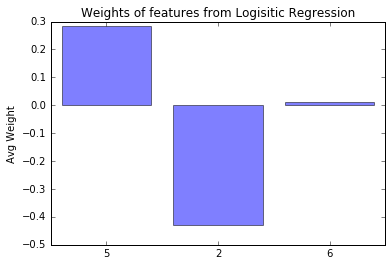

Training with all clusters
LOGISTIC
fold: 0  best c: 0.3  dev:0.68  dev_ones:0.48   {'7': 0.0, '3': 0.0, '5': 0.0, '4': 0.0, '6': 0.0}
 test:0.56  train:0.61
fold: 1  best c: 0.3  dev:0.69  dev_ones:0.47   {'7': 0.0, '3': 0.0, '5': 0.0, '4': 0.0, '6': 0.0}
 test:0.47  train:0.62
fold: 2  best c: 0.3  dev:0.66  dev_ones:0.47   {'0': 0.0, '3': 0.0, '5': 0.0, '4': 0.0, '6': 0.0}
 test:0.43  train:0.63
fold: 3  best c: 1  dev:0.66  dev_ones:0.50   {'3': 0.0}
 test:0.64  train:0.64
fold: 4  best c: 0.3  dev:0.69  dev_ones:0.47   {'3': 0.0, '4': 0.0}
 test:0.50  train:0.66
fold: 5  best c: 30  dev:0.62  dev_ones:0.50   {'5': 0.0}
 test:0.64  train:0.62
fold: 6  best c: 1  dev:0.69  dev_ones:0.50   {'5': 0.0, '6': 0.0}
 test:0.50  train:0.64
fold: 7  best c: 10  dev:0.66  dev_ones:0.47   {'5': 0.0}
 test:0.79  train:0.59
fold: 8  best c: 0.1  dev:0.59  dev_ones:0.50   {'0': 0.0, '5': 0.0, '6': 0.0, '4': 0.0, '3': 0.0, '7': 0.0}
 test:0.50  train:0.60
fold: 9  best c: 1  dev:0.72  dev_ones:0.5

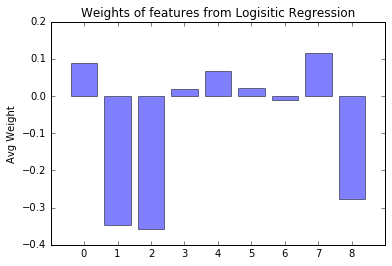

Training with all clusters and gender
LOGISTIC
fold: 0  best c: 0.3  dev:0.68  dev_ones:0.48   {'5': 0.0, 'witness_is_male': 0.0, '6': 0.0, '4': 0.0, '3': 0.0, '7': 0.0}
 test:0.56  train:0.61
fold: 1  best c: 0.3  dev:0.69  dev_ones:0.47   {'5': 0.0, 'witness_is_male': 0.0, '6': 0.0, '4': 0.0, '3': 0.0, '7': 0.0}
 test:0.47  train:0.62
fold: 2  best c: 0.3  dev:0.66  dev_ones:0.47   {'5': 0.0, 'witness_is_male': 0.0, '0': 0.0, '4': 0.0, '3': 0.0, '6': 0.0}
 test:0.43  train:0.63
fold: 3  best c: 1  dev:0.66  dev_ones:0.50   {'3': 0.0, 'witness_is_male': 0.0}
 test:0.64  train:0.64
fold: 4  best c: 0.3  dev:0.69  dev_ones:0.47   {'3': 0.0, 'witness_is_male': 0.0, '4': 0.0}
 test:0.50  train:0.66
fold: 5  best c: 0.3  dev:0.56  dev_ones:0.50   {'5': 0.0, 'witness_is_male': 0.0, '6': 0.0, '4': 0.0, '3': 0.0, '7': 0.0}
 test:0.64  train:0.62
fold: 6  best c: 1  dev:0.69  dev_ones:0.50   {'5': 0.0, 'witness_is_male': 0.0, '6': 0.0}
 test:0.50  train:0.64
fold: 7  best c: 0.3  dev:0.62  dev

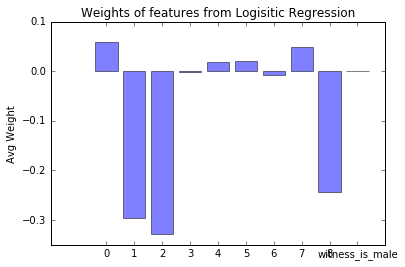

Training with clusters with high weights
LOGISTIC
fold: 0  best c: 0.3  dev:0.71  dev_ones:0.48   {}
 test:0.56  train:0.61
fold: 1  best c: 3  dev:0.69  dev_ones:0.47   {}
 test:0.47  train:0.62
fold: 2  best c: 1  dev:0.69  dev_ones:0.47   {}
 test:0.43  train:0.62
fold: 3  best c: 0.3  dev:0.69  dev_ones:0.50   {}
 test:0.64  train:0.62
fold: 4  best c: 0.3  dev:0.62  dev_ones:0.47   {}
 test:0.64  train:0.59
fold: 5  best c: 1  dev:0.72  dev_ones:0.50   {}
 test:0.64  train:0.59
fold: 6  best c: 0.3  dev:0.72  dev_ones:0.50   {}
 test:0.43  train:0.61
fold: 7  best c: 1  dev:0.62  dev_ones:0.47   {}
 test:0.71  train:0.60
fold: 8  best c: 3  dev:0.69  dev_ones:0.50   {}
 test:0.64  train:0.59
fold: 9  best c: 1  dev:0.72  dev_ones:0.50   {}
 test:0.79  train:0.59
Avg test acc:0.596 Avg train acc:0.604


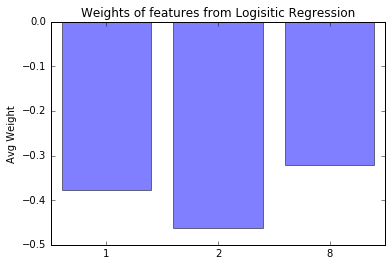

In [31]:
print('Training with clusters of high p-values for male witnesses')
ml(df_bmm9m[usecols652],'LOGISTIC',1)
print('Training with all clusters')
ml(df_bmm9_gr[usecols],'LOGISTIC',1)
print('Training with all clusters and gender')
ml(df_bmm9_gr[usecolsgen],'LOGISTIC',1)
print('Training with clusters with high weights')
usecol = ['y','1','2','8']
ml(df_bmm9_gr[usecol],'LOGISTIC',1)


#### Subsetting on only male witnesses for logistic regression weight analysis

only subset of male witnesses and using all clusters
LOGISTIC
fold: 0  best c: 1  dev:0.69  dev_ones:0.56   {'7': 0.0, '4': 0.0}
 test:0.50  train:0.70
fold: 1  best c: 3  dev:0.75  dev_ones:0.56   {'3': 0.0, '5': 0.0}
 test:0.75  train:0.70
fold: 2  best c: 0.3  dev:0.62  dev_ones:0.50   {'7': 0.0, '0': 0.0, '4': 0.0, '6': 0.0}
 test:0.75  train:0.69
fold: 3  best c: 1  dev:0.75  dev_ones:0.50   {'7': 0.0, '4': 0.0}
 test:0.62  train:0.66
fold: 4  best c: 0.3  dev:0.62  dev_ones:0.56   {'7': 0.0, '3': 0.0, '4': 0.0, '6': 0.0}
 test:0.50  train:0.67
fold: 5  best c: 1  dev:0.69  dev_ones:0.50   {'7': 0.0, '4': 0.0}
 test:0.75  train:0.67
fold: 6  best c: 0.3  dev:0.76  dev_ones:0.53   {'0': 0.0, '5': 0.0, '8': 0.0, '6': 0.0, '4': 0.0, '7': 0.0}
 test:0.57  train:0.69
fold: 7  best c: 1  dev:0.59  dev_ones:0.53   {'5': 0.0, '7': 0.0, '4': 0.0}
 test:0.57  train:0.69
fold: 8  best c: 1  dev:0.76  dev_ones:0.47   {'7': 0.0, '4': 0.0}
 test:0.29  train:0.76
fold: 9  best c: 3  dev:0.71  de

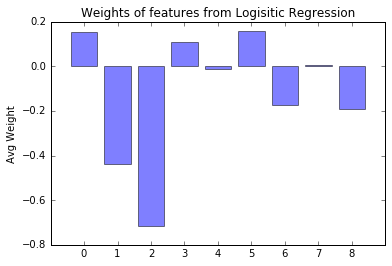

including interrogator gender
LOGISTIC
fold: 0  best c: 1  dev:0.75  dev_ones:0.56   {}
 test:0.50  train:0.75
fold: 1  best c: 3  dev:0.81  dev_ones:0.56   {}
 test:0.75  train:0.69
fold: 2  best c: 0.3  dev:0.62  dev_ones:0.50   {'6': 0.0, '0': 0.0, 'interrogator_is_male': 0.0}
 test:0.62  train:0.66
fold: 3  best c: 1  dev:0.81  dev_ones:0.50   {'interrogator_is_male': 0.0}
 test:0.62  train:0.69
fold: 4  best c: 0.3  dev:0.62  dev_ones:0.56   {'6': 0.0, 'interrogator_is_male': 0.0}
 test:0.62  train:0.67
fold: 5  best c: 1  dev:0.75  dev_ones:0.50   {'interrogator_is_male': 0.0}
 test:0.88  train:0.67
fold: 6  best c: 0.3  dev:0.76  dev_ones:0.53   {'5': 0.0, '6': 0.0, '0': 0.0, 'interrogator_is_male': 0.0}
 test:0.57  train:0.69
fold: 7  best c: 3  dev:0.65  dev_ones:0.53   {'5': 0.0}
 test:0.57  train:0.72
fold: 8  best c: 10  dev:0.76  dev_ones:0.47   {}
 test:0.29  train:0.75
fold: 9  best c: 3  dev:0.71  dev_ones:0.53   {}
 test:0.83  train:0.67
Avg test acc:0.626 Avg train ac

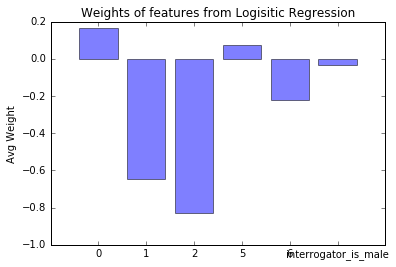

including clusters of high weights only
LOGISTIC
fold: 0  best c: 0.3  dev:0.69  dev_ones:0.56   {}
 test:0.50  train:0.69
fold: 1  best c: 1  dev:0.69  dev_ones:0.56   {}
 test:0.75  train:0.66
fold: 2  best c: 1  dev:0.62  dev_ones:0.50   {}
 test:0.88  train:0.66
fold: 3  best c: 0.3  dev:0.75  dev_ones:0.50   {}
 test:0.62  train:0.67
fold: 4  best c: 0.3  dev:0.69  dev_ones:0.56   {}
 test:0.75  train:0.66
fold: 5  best c: 3  dev:0.69  dev_ones:0.50   {}
 test:0.75  train:0.67
fold: 6  best c: 1  dev:0.76  dev_ones:0.53   {}
 test:0.71  train:0.68
fold: 7  best c: 1  dev:0.59  dev_ones:0.53   {}
 test:0.57  train:0.66
fold: 8  best c: 1  dev:0.76  dev_ones:0.47   {}
 test:0.29  train:0.71
fold: 9  best c: 0.3  dev:0.65  dev_ones:0.53   {}
 test:0.83  train:0.67
Avg test acc:0.665 Avg train acc:0.671


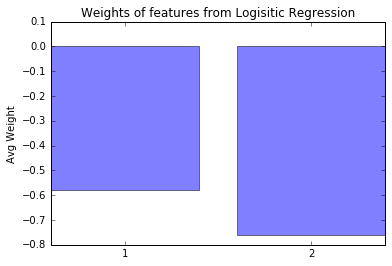

SVC
fold: 0  best c: 3  dev:0.69  dev_ones:0.56 test:0.62  train:0.70
fold: 1  best c: 300  dev:0.75  dev_ones:0.56 test:0.38  train:0.76
fold: 2  best c: 1  dev:0.62  dev_ones:0.50 test:0.62  train:0.67
fold: 3  best c: 1000  dev:0.81  dev_ones:0.50 test:0.50  train:0.76
fold: 4  best c: 300  dev:0.88  dev_ones:0.56 test:0.50  train:0.76
fold: 5  best c: 1000  dev:0.75  dev_ones:0.50 test:0.75  train:0.75
fold: 6  best c: 300  dev:0.76  dev_ones:0.53 test:0.43  train:0.76
fold: 7  best c: 1000  dev:0.71  dev_ones:0.53 test:0.57  train:0.72
fold: 8  best c: 0.1  dev:0.71  dev_ones:0.47 test:0.29  train:0.69
fold: 9  best c: 3  dev:0.65  dev_ones:0.53 test:0.83  train:0.62
Avg test acc:0.549 Avg train acc:0.720


In [32]:
## Analyzing with only subset of male
usecolsall1= ['y','0','1','2','3','4','5','6','7','8']
print('only subset of male witnesses and using all clusters')
ml(df_bmm9m[usecolsall1],'LOGISTIC',1)
print('including interrogator gender')
usecolsi1=['y','0','1','2','5','6','interrogator_is_male']
ml(df_bmm9m[usecolsi1],'LOGISTIC',1)
print ('including clusters of high weights only')
usecolsr=['y','1','2']
ml(df_bmm9m[usecolsr],'LOGISTIC',1)
ml(df_bmm9m[usecolsr],'SVC')

#### Subsetting on only female witnesses for logistic regression weight analysis
       turns out stats significant clusters were given most weights as well

Looking at all clusters
LOGISTIC
fold: 0  best c: 1  dev:0.67  dev_ones:0.47   {'0': 0.0, '5': 0.0, '2': 0.0, '6': 0.0}
 test:0.50  train:0.67
fold: 1  best c: 1  dev:0.80  dev_ones:0.47   {'0': 0.0, '5': 0.0, '2': 0.0, '4': 0.0, '3': 0.0, '6': 0.0}
 test:0.50  train:0.60
fold: 2  best c: 0.3  dev:0.73  dev_ones:0.40   {'4': 0.0, '0': 0.0, '5': 0.0, '2': 0.0, '6': 0.0}
 test:0.25  train:0.65
fold: 3  best c: 1  dev:0.73  dev_ones:0.40   {'0': 0.0, '4': 0.0, '2': 0.0}
 test:0.43  train:0.62
fold: 4  best c: 3  dev:0.67  dev_ones:0.47   {'3': 0.0, '6': 0.0}
 test:0.43  train:0.64
fold: 5  best c: 0.01  dev:0.53  dev_ones:0.47   {'0': 0.0, '5': 0.0, '1': 0.0, '2': 0.0, '4': 0.0, '7': 0.0, '3': 0.0, '8': 0.0, '6': 0.0}
 test:0.50  train:0.48
fold: 6  best c: 1  dev:0.73  dev_ones:0.47   {'4': 0.0, '5': 0.0, '2': 0.0, '6': 0.0}
 test:0.50  train:0.61
fold: 7  best c: 10  dev:0.67  dev_ones:0.47   {'2': 0.0}
 test:0.50  train:0.60
fold: 8  best c: 1  dev:0.73  dev_ones:0.47   {'5': 0.0, '4':

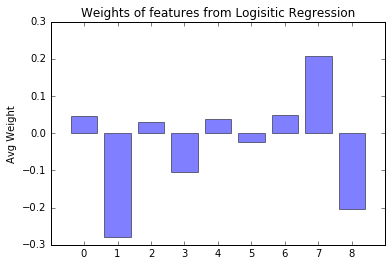

only statistically significant clusters
LOGISTIC
fold: 0  best c: 3  dev:0.73  dev_ones:0.47   {}
 test:0.50  train:0.68
fold: 1  best c: 0.3  dev:0.73  dev_ones:0.47   {'7': 0.0}
 test:0.62  train:0.63
fold: 2  best c: 0.3  dev:0.73  dev_ones:0.40   {}
 test:0.25  train:0.60
fold: 3  best c: 3  dev:0.73  dev_ones:0.40   {}
 test:0.43  train:0.64
fold: 4  best c: 1  dev:0.73  dev_ones:0.47   {}
 test:0.71  train:0.62
fold: 5  best c: 10  dev:0.67  dev_ones:0.47   {}
 test:0.33  train:0.65
fold: 6  best c: 0.3  dev:0.80  dev_ones:0.47   {'7': 0.0}
 test:0.50  train:0.65
fold: 7  best c: 3  dev:0.73  dev_ones:0.47   {}
 test:0.50  train:0.61
fold: 8  best c: 1  dev:0.73  dev_ones:0.47   {}
 test:0.67  train:0.63
fold: 9  best c: 0.3  dev:0.73  dev_ones:0.40   {'7': 0.0}
 test:0.50  train:0.65
Avg test acc:0.502 Avg train acc:0.636


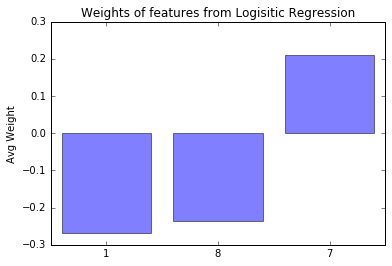

including interrogator gender to statistically sig clusters
LOGISTIC
fold: 0  best c: 0.01  dev:0.53  dev_ones:0.47   {'1': 0.0, '8': 0.0, 'interrogator_is_male': 0.0}
 test:0.50  train:0.48
fold: 1  best c: 0.3  dev:0.73  dev_ones:0.47   {'interrogator_is_male': 0.0}
 test:0.62  train:0.63
fold: 2  best c: 0.3  dev:0.73  dev_ones:0.40   {'interrogator_is_male': 0.0}
 test:0.25  train:0.63
fold: 3  best c: 0.3  dev:0.73  dev_ones:0.40   {'interrogator_is_male': 0.0}
 test:0.71  train:0.62
fold: 4  best c: 1  dev:0.60  dev_ones:0.47   {'interrogator_is_male': 0.0}
 test:0.71  train:0.61
fold: 5  best c: 0.01  dev:0.53  dev_ones:0.47   {'1': 0.0, '8': 0.0, 'interrogator_is_male': 0.0}
 test:0.50  train:0.48
fold: 6  best c: 0.3  dev:0.80  dev_ones:0.47   {'interrogator_is_male': 0.0}
 test:0.50  train:0.65
fold: 7  best c: 1  dev:0.67  dev_ones:0.47   {'interrogator_is_male': 0.0}
 test:0.50  train:0.65
fold: 8  best c: 3  dev:0.67  dev_ones:0.47   {}
 test:0.50  train:0.63
fold: 9  best

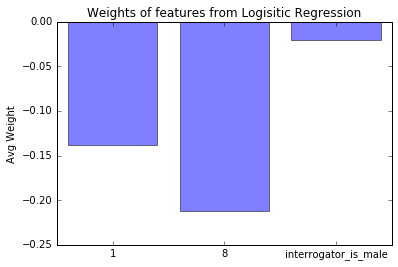

SVC
fold: 0  best c: 1  dev:0.67  dev_ones:0.47 test:0.25  train:0.67
fold: 1  best c: 10  dev:0.60  dev_ones:0.47 test:0.38  train:0.75
fold: 2  best c: 3  dev:0.60  dev_ones:0.40 test:0.38  train:0.70
fold: 3  best c: 3  dev:0.60  dev_ones:0.40 test:0.57  train:0.70
fold: 4  best c: 0.01  dev:0.47  dev_ones:0.47 test:0.57  train:0.51
fold: 5  best c: 3  dev:0.53  dev_ones:0.47 test:0.17  train:0.71
fold: 6  best c: 300  dev:0.60  dev_ones:0.47 test:0.50  train:0.76
fold: 7  best c: 3  dev:0.60  dev_ones:0.47 test:0.50  train:0.71
fold: 8  best c: 10  dev:0.67  dev_ones:0.47 test:0.67  train:0.69
fold: 9  best c: 10  dev:0.53  dev_ones:0.40 test:0.33  train:0.73
Avg test acc:0.431 Avg train acc:0.693


In [33]:
usecolsallf1= ['y','0','1','2','3','4','5','6','7','8']
usecolsf1=['y','1','8','7']
usecolsif1=['y','1','8','interrogator_is_male']

print('Looking at all clusters')
ml(df_bmm9f[usecolsallf1],'LOGISTIC',1)
print('only statistically significant clusters')
ml(df_bmm9f[usecolsf1],'LOGISTIC',1)
print('including interrogator gender to statistically sig clusters')
ml(df_bmm9f[usecolsif1],'LOGISTIC',1)
ml(df_bmm9f[usecolsf1],'SVC')

# Exploring correlations with BMM9 clusters

In [14]:
corcol= ['0','1','2','3','4','5','6','7','8']
print('with no subsetting data')
display(df_bmm9_gr[corcol].corr())
print('with subset of male')
display(df_bmm9m[corcol].corr())
print('with subset of female')
display(df_bmm9f[corcol].corr())

with no subsetting data


,0,1,2,3,4,5,6,7,8
0,1.0000,-0.2340,-0.2939,-0.1168,-0.1623,0.1307,0.4708,-0.1993,-0.1527
1,-0.2340,1.0000,-0.2422,-0.2208,-0.2195,-0.2044,-0.1520,0.3994,0.5658
2,-0.2939,-0.2422,1.0000,0.0639,0.3679,-0.3826,-0.2456,-0.4636,-0.1747
3,-0.1168,-0.2208,0.0639,1.0000,-0.1946,-0.5017,0.0349,-0.4098,-0.1224
4,-0.1623,-0.2195,0.3679,-0.1946,1.0000,0.1085,-0.2753,-0.3908,-0.0773
5,0.1307,-0.2044,-0.3826,-0.5017,0.1085,1.0000,-0.2167,0.1309,-0.1094
6,0.4708,-0.1520,-0.2456,0.0349,-0.2753,-0.2167,1.0000,-0.2205,-0.0748
7,-0.1993,0.3994,-0.4636,-0.4098,-0.3908,0.1309,-0.2205,1.0000,0.0779
8,-0.1527,0.5658,-0.1747,-0.1224,-0.0773,-0.1094,-0.0748,0.0779,1.0000


with subset of male


,0,1,2,3,4,5,6,7,8
0,1.0000,-0.2688,-0.2975,-0.0050,-0.1729,0.1148,0.6811,-0.2896,-0.1505
1,-0.2688,1.0000,-0.2845,-0.2590,-0.2610,-0.2087,-0.1889,0.5003,0.6197
2,-0.2975,-0.2845,1.0000,-0.0276,0.2558,-0.4006,-0.2612,-0.4709,-0.1675
3,-0.0050,-0.2590,-0.0276,1.0000,-0.2109,-0.4768,0.1066,-0.4073,-0.1415
4,-0.1729,-0.2610,0.2558,-0.2109,1.0000,0.1701,-0.2568,-0.3677,-0.1750
5,0.1148,-0.2087,-0.4006,-0.4768,0.1701,1.0000,-0.1293,0.1638,-0.1911
6,0.6811,-0.1889,-0.2612,0.1066,-0.2568,-0.1293,1.0000,-0.2249,-0.1214
7,-0.2896,0.5003,-0.4709,-0.4073,-0.3677,0.1638,-0.2249,1.0000,0.1775
8,-0.1505,0.6197,-0.1675,-0.1415,-0.1750,-0.1911,-0.1214,0.1775,1.0000


with subset of female


,0,1,2,3,4,5,6,7,8
0,1.0000,-0.1866,-0.3493,-0.2949,-0.1714,0.1852,0.4561,-0.0753,-0.1466
1,-0.1866,1.0000,-0.2128,-0.1808,-0.1810,-0.1980,-0.1406,0.3133,0.5078
2,-0.3493,-0.2128,1.0000,0.1844,0.5153,-0.3605,-0.2489,-0.4575,-0.1563
3,-0.2949,-0.1808,0.1844,1.0000,-0.1817,-0.5269,0.0036,-0.4139,-0.1006
4,-0.1714,-0.1810,0.5153,-0.1817,1.0000,0.0727,-0.2968,-0.4048,0.0538
5,0.1852,-0.1980,-0.3605,-0.5269,0.0727,1.0000,-0.2873,0.0899,-0.0503
6,0.4561,-0.1406,-0.2489,0.0036,-0.2968,-0.2873,1.0000,-0.2523,-0.0750
7,-0.0753,0.3133,-0.4575,-0.4139,-0.4048,0.0899,-0.2523,1.0000,-0.0407
8,-0.1466,0.5078,-0.1563,-0.1006,0.0538,-0.0503,-0.0750,-0.0407,1.0000
